In [1]:
from src.network.customics import CustOMICS
from src.tools.prepare_dataset import prepare_dataset
from src.tools.utils import get_sub_omics_df
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
omics_df = {'protein': pd.read_csv('toy_data/protein.txt', sep='\t', index_col=0, header=0).T,
            'gene_exp': pd.read_csv('toy_data/gene_exp.txt', sep='\t', index_col=0, header=0).T,
            'methyl': pd.read_csv('toy_data/methyl.txt', sep='\t', index_col=0, header=0).T
            }
clinical_df = pd.read_csv('toy_data/labels.txt', sep='\t', index_col=1, header=0)

In [3]:
lt_samples = list(clinical_df.index)

In [4]:
samples_train, samples_test = train_test_split(lt_samples, test_size=0.2)
samples_train, samples_val = train_test_split(samples_train, test_size=0.2)

In [5]:
omics_train = get_sub_omics_df(omics_df, samples_train)
omics_val = get_sub_omics_df(omics_df, samples_val)
omics_test = get_sub_omics_df(omics_df, samples_test)


x_dim = [omics_df[omic_source].shape[1] for omic_source in omics_df.keys()]

In [6]:
#### Defining Hyperparameters

batch_size = 32
n_epochs = 10
device = torch.device('cpu')
label = 'cluster.id'
event = 'cluster.id'
surv_time = 'cluster.id'

task = 'classification'
sources = ['gene_exp', 'methyl', 'protein']

hidden_dim = [512, 256]
central_dim = [512, 256]
rep_dim = 128
latent_dim=128
num_classes = 5
dropout = 0.2
beta = 1
lambda_classif = 5
classifier_dim = [128, 64]
lambda_survival = 0
survival_dim = [64,32]

source_params = {}
central_params = {'hidden_dim': central_dim, 'latent_dim': latent_dim, 'norm': True, 'dropout': dropout, 'beta': beta}
classif_params = {'n_class': num_classes, 'lambda': lambda_classif, 'hidden_layers': classifier_dim, 'dropout': dropout}
surv_params = {'lambda': lambda_survival, 'dims': survival_dim, 'activation': 'SELU', 'l2_reg': 1e-2, 'norm': True, 'dropout': dropout}
for i, source in enumerate(sources):
    source_params[source] = {'input_dim': x_dim[i], 'hidden_dim': hidden_dim, 'latent_dim': rep_dim, 'norm': True, 'dropout': 0.2}
train_params = {'switch': 5, 'lr': 1e-3}

Number of Parameters:  2294930
	Epoch 1 complete! 	Average Loss Train :  0.9586234092712402 	Average Loss Val :  0.9895243644714355
	Epoch 2 complete! 	Average Loss Train :  0.6410591006278992 	Average Loss Val :  0.8812313079833984
	Epoch 3 complete! 	Average Loss Train :  0.4803233742713928 	Average Loss Val :  0.6996078491210938
	Epoch 4 complete! 	Average Loss Train :  0.3931749016046524 	Average Loss Val :  0.5140991806983948
	Epoch 5 complete! 	Average Loss Train :  0.3258792608976364 	Average Loss Val :  0.3804987072944641
	Epoch 6 complete! 	Average Loss Train :  0.32822728157043457 	Average Loss Val :  0.3150279223918915
	Epoch 7 complete! 	Average Loss Train :  0.19271544367074966 	Average Loss Val :  0.21414199471473694
	Epoch 8 complete! 	Average Loss Train :  0.1597532033920288 	Average Loss Val :  0.14333146810531616
	Epoch 9 complete! 	Average Loss Train :  0.14022678136825562 	Average Loss Val :  0.10872457176446915
	Epoch 10 complete! 	Average Loss Train :  0.130489543

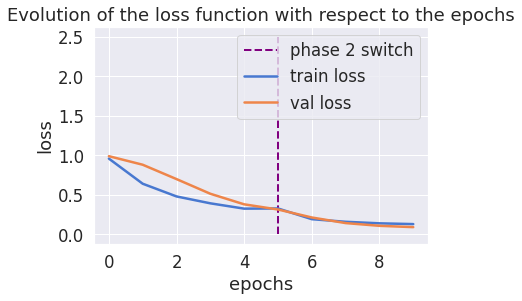

In [7]:
model = CustOMICS(source_params=source_params, central_params=central_params, classif_params=classif_params,
                        surv_params=surv_params, train_params=train_params, device=device).to(device)
print('Number of Parameters: ', model.get_number_parameters())
model.fit(omics_train=omics_train, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
            omics_val=omics_val, batch_size=batch_size, n_epochs=n_epochs, verbose=True)
metric = model.evaluate(omics_test=omics_test, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
                task=task, batch_size=1024, plot_roc=False)
model.plot_loss()


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


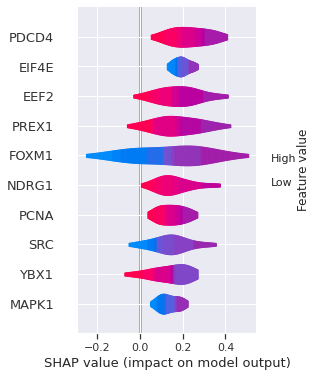

<Figure size 432x288 with 0 Axes>

In [9]:
model.explain(lt_samples, omics_df, clinical_df, 'gene_exp', 1, 'cluster.id', device, show=True)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


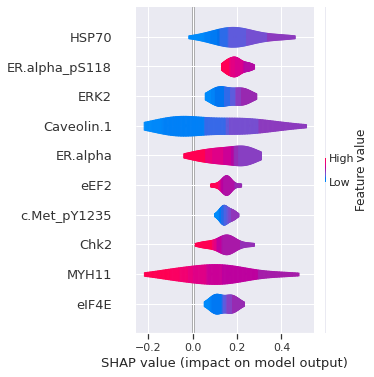

<Figure size 432x288 with 0 Axes>

In [10]:
model.explain(lt_samples, omics_df, clinical_df, 'protein', 1, 'cluster.id', device, show=True)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


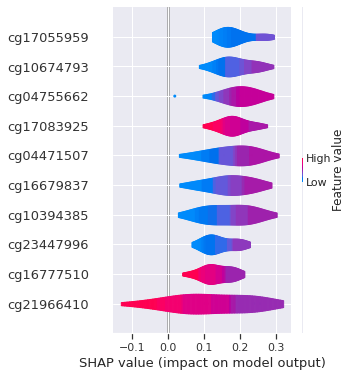

<Figure size 432x288 with 0 Axes>

In [11]:
model.explain(lt_samples, omics_df, clinical_df, 'methyl', 1, 'cluster.id', device, show=True)